In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
years = 5
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

In [4]:
plotdepths = mymesh.gdept_1d[0,:34]
plotdepths = np.append(0,plotdepths)

## Functions

In [5]:
def get_data(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.final_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.final_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [6]:
def get_all_data_SoG(folder):
    yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+'forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [7]:
back_mo = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']

def BACK_get_all_data_SoG(folder):
    yearjumps = [0,1,0,1,1,0,1,0,1,-2,1,0]
    starttime = 721
    endtime = 1440

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0
    
    #2016 (month by month)
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'16/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2017 and 2018
    k=12
    year = [17,18]
    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=24

    #2019 and (month by month)
    k=36
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'19/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))
    
    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [8]:
#same get data function but for initial instead of final
def get_data_init(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.init_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.init_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.init_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [9]:
def get_all_data_SoG_init(folder):
    yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+'forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.init_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.init_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.init_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.init_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+'forward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [10]:
def BACK_get_all_data_SoG_init(folder):
    yearjumps = [0,1,0,1,1,0,1,0,1,-2,1,0]
    starttime = 721
    endtime = 1440

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0
    
    #2016 (month by month)
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'16/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.init_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.init_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.init_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.init_salt[(mydata.final_section==section)]),i+k+1))

    #2017 and 2018
    k=12
    year = [17,18]
    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=24

    #2019 and (month by month)
    k=36
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'19/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.init_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.init_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.init_transp[(mydata.final_section==section)]/720)
            month = np.append(month, np.full(len(mydata.init_salt[(mydata.final_section==section)]),i+k+1))
    
    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data_init(mydata, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

## Net flux into the SoG

In [11]:
#FINAL
#forward
folder = 'Car_Sal'
CS_depths, CS_transports, carbon, salinity, CS_month = get_all_data_SoG(folder)
folder = 'Nit_Sil'
NS_depths, NS_transports, nitrate, silicate, NS_month = get_all_data_SoG(folder)
#backwards
folder = 'Car_Sal'
B_CS_depths, B_CS_transports, Bcarbon, Bsalinity, B_CS_month = BACK_get_all_data_SoG(folder)
folder = 'Nit_Sil'
B_NS_depths, B_NS_transports, Bnitrate, Bsilicate, B_NS_month = BACK_get_all_data_SoG(folder)

In [12]:
#INIT
#forward
folder = 'Car_Sal'
CS_depths_I, CS_transports_I, carbon_I, salinity_I, CS_month_I = get_all_data_SoG_init(folder)
folder = 'Nit_Sil'
NS_depths_I, NS_transports_I, nitrate_I, silicate_I, NS_month_I = get_all_data_SoG_init(folder)
#backwards
folder = 'Car_Sal'
B_CS_depths_I, B_CS_transports_I, Bcarbon_I, Bsalinity_I, B_CS_month_I = BACK_get_all_data_SoG_init(folder)
folder = 'Nit_Sil'
B_NS_depths_I, B_NS_transports_I, Bnitrate_I, Bsilicate_I, B_NS_month_I = BACK_get_all_data_SoG_init(folder)

In [53]:
#forward final Salinity and Carbon
d = {'carbon': carbon, 'salinity': salinity, 'transport': CS_transports, 'month':CS_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_for = np.array([])
carb_sum_for = np.array([])
trans_sum_for = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    trans_sum_for = np.append(trans_sum_for,sum(transports))
    carb_sum_for = np.append(carb_sum_for,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_for = np.append(saln_sum_for,sum(tracerSa*transports))  

In [54]:
#backward final Salinity and Carbon
d = {'carbon': Bcarbon, 'salinity': Bsalinity, 'transport': B_CS_transports, 'month':B_CS_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_back = np.array([])
carb_sum_back = np.array([])
trans_sum_back = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    trans_sum_back = np.append(trans_sum_back,sum(transports))
    carb_sum_back = np.append(carb_sum_back,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_back = np.append(saln_sum_back,sum(tracerSa*transports))  

In [55]:
#forward final Nitrate and Silicon
d = {'nitrate': nitrate, 'silicon': silicate, 'transport': NS_transports, 'month':NS_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_for = np.array([])
sili_sum_for = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_for = np.append(nitr_sum_for,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_for = np.append(sili_sum_for,sum(tracerSi*transports)/1000*(60.08/1000))

In [56]:
#backward final Nitrate and Silicon
d = {'nitrate': Bnitrate, 'silicon': Bsilicate, 'transport': B_NS_transports, 'month':B_NS_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_back = np.array([])
sili_sum_back = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_back = np.append(nitr_sum_back,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_back = np.append(sili_sum_back,sum(tracerSi*transports)/1000*(60.08/1000))

In [57]:
#forward init Salinity and Carbon
d = {'carbon': carbon_I, 'salinity': salinity_I, 'transport': CS_transports_I, 'month':CS_month_I}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_for_I = np.array([])
carb_sum_for_I = np.array([])
trans_sum_for_I = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    carb_sum_for_I = np.append(carb_sum_for_I,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_for_I = np.append(saln_sum_for_I,sum(tracerSa*transports))  

In [58]:
#backward init Salinity and Carbon
d = {'carbon': Bcarbon_I, 'salinity': Bsalinity_I, 'transport': B_CS_transports_I, 'month':B_CS_month_I}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_back_I = np.array([])
carb_sum_back_I = np.array([])
trans_sum_back_I = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    carb_sum_back_I = np.append(carb_sum_back_I,sum(tracerC*transports)/1000*(44.01/1000))
    saln_sum_back_I = np.append(saln_sum_back_I,sum(tracerSa*transports))

In [59]:
#forward init Nitrate and Silicon
d = {'nitrate': nitrate_I, 'silicon': silicate_I, 'transport': NS_transports_I, 'month':NS_month_I}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_for_I = np.array([])
sili_sum_for_I = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_for_I = np.append(nitr_sum_for_I,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_for_I = np.append(sili_sum_for_I,sum(tracerSi*transports)/1000*(60.08/1000))

In [60]:
#backward init Nitrate and Silicon
d = {'nitrate': Bnitrate_I, 'silicon': Bsilicate_I, 'transport': B_NS_transports_I, 'month':B_NS_month_I}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_back_I = np.array([])
sili_sum_back_I = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_back_I = np.append(nitr_sum_back_I,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_back_I = np.append(sili_sum_back_I,sum(tracerSi*transports)/1000*(60.08/1000))

(1, 10000000)

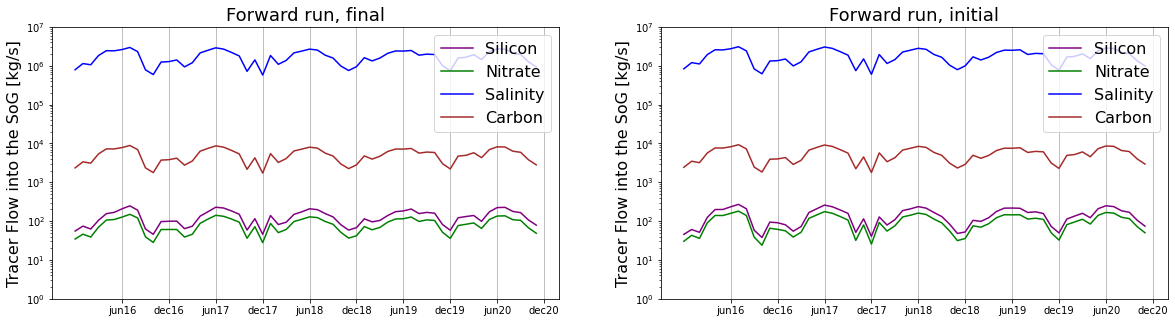

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(sili_sum_for,label='Silicon', c='purple')
ax[0].plot(nitr_sum_for,label='Nitrate', c='green')
ax[0].plot(saln_sum_for,label='Salinity', c='b')
ax[0].plot(carb_sum_for,label='Carbon', c='brown')

ax[0].legend(fontsize = 16)
ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(6,61,6))
ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[0].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[0].grid(axis='x', which='both')
ax[0].set_title("Forward run, final",fontsize = 18)
ax[0].set_ylim(1,10**7)

ax[1].plot(sili_sum_for_I,label='Silicon', c='purple')
ax[1].plot(nitr_sum_for_I,label='Nitrate', c='green')
ax[1].plot(saln_sum_for_I,label='Salinity', c='b')
ax[1].plot(carb_sum_for_I,label='Carbon', c='brown')

ax[1].legend(fontsize = 16)
ax[1].set_yscale('log')
ax[1].set_xticks(np.arange(6,61,6))
ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[1].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[1].grid(axis='x', which='both')
ax[1].set_title("Forward run, initial",fontsize = 18)
ax[1].set_ylim(1,10**7)

(1, 10000000)

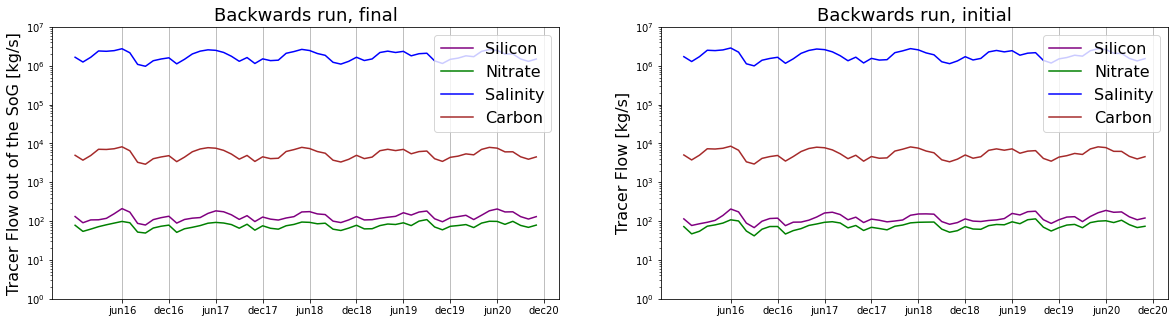

In [97]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(sili_sum_back,label='Silicon', c='purple')
ax[0].plot(nitr_sum_back,label='Nitrate', c='green')
ax[0].plot(saln_sum_back,label='Salinity', c='b')
ax[0].plot(carb_sum_back,label='Carbon', c='brown')

ax[0].legend(fontsize = 16)
ax[0].set_yscale('log')
ax[0].set_xticks(np.arange(6,61,6))
ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[0].set_ylabel('Tracer Flow out of the SoG [kg/s]', fontsize = 16)
ax[0].grid(axis='x', which='both')
ax[0].set_title("Backwards run, final",fontsize = 18)
ax[0].set_ylim(1,10**7)

ax[1].plot(sili_sum_back_I,label='Silicon', c='purple')
ax[1].plot(nitr_sum_back_I,label='Nitrate', c='green')
ax[1].plot(saln_sum_back_I,label='Salinity', c='b')
ax[1].plot(carb_sum_back_I,label='Carbon', c='brown')

ax[1].legend(fontsize = 16)
ax[1].set_yscale('log')
ax[1].set_xticks(np.arange(6,61,6))
ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[1].set_ylabel('Tracer Flow [kg/s]', fontsize = 16)
ax[1].grid(axis='x', which='both')
ax[1].set_title("Backwards run, initial",fontsize = 18)
ax[1].set_ylim(1,10**7)

Text(0.5, 1.0, 'Forwards - Backwards run, initial')

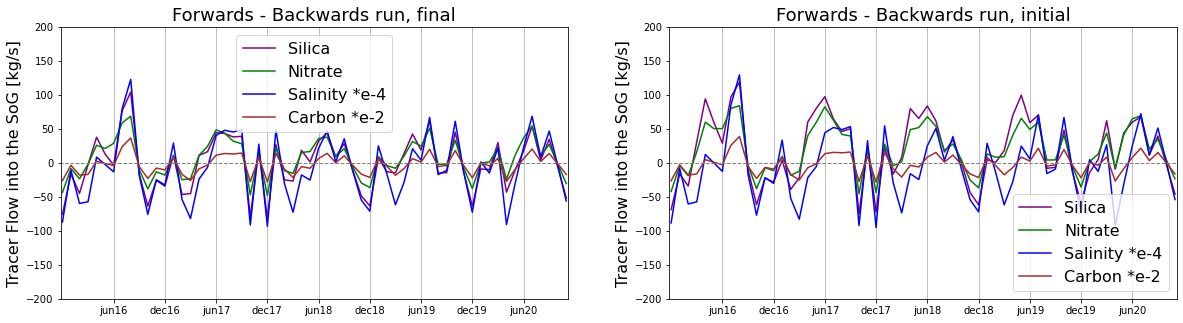

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].plot(sili_sum_for-sili_sum_back,label='Silica', c='purple')
ax[0].plot(nitr_sum_for-nitr_sum_back,label='Nitrate', c='green')
ax[0].plot((saln_sum_for-saln_sum_back)/10000,label='Salinity *e-4', c='b')
ax[0].plot((carb_sum_for-carb_sum_back)/100,label='Carbon *e-2', c='brown')

ax[0].plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax[0].legend(fontsize = 16)
ax[0].set_ylim([-200,200])
# ax.set_yscale('log')
ax[0].set_xticks(np.arange(6,61,6))
ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[0].set_xlim(-0.2,60-0.8)
ax[0].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[0].grid(axis='x', which='both')
ax[0].set_title("Forwards - Backwards run, final",fontsize = 18)

ax[1].plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax[1].legend(fontsize = 16)
ax[1].set_ylim([-200,200])
# ax.set_yscale('log')
ax[1].set_xticks(np.arange(6,61,6))
ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[1].set_xlim(-0.2,60-0.8)
ax[1].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[1].grid(axis='x', which='both')
ax[1].set_title("Forwards - Backwards run, initial",fontsize = 18)

Text(0.5, 1.0, 'Backwards runs, final - initial')

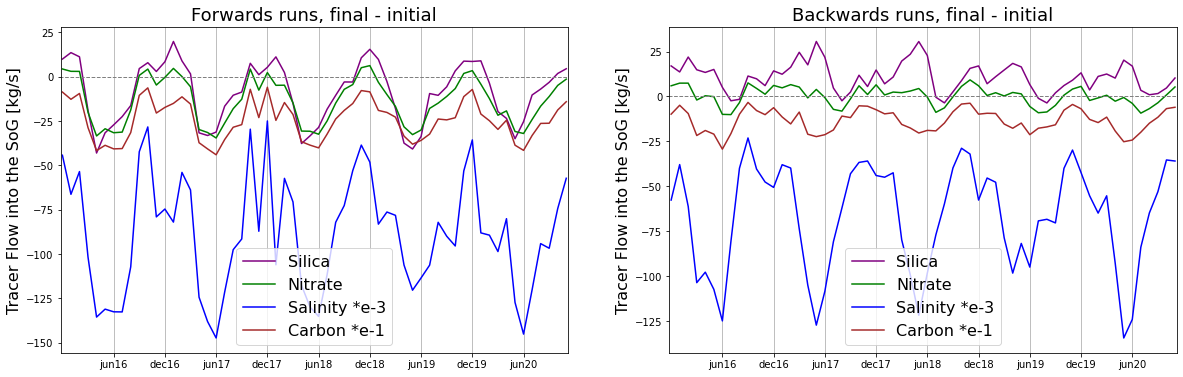

In [85]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

ax[0].plot(sili_sum_for-sili_sum_for_I,label='Silica', c='purple')
ax[0].plot(nitr_sum_for-nitr_sum_for_I,label='Nitrate', c='green')
ax[0].plot((saln_sum_for-saln_sum_for_I)/1000,label='Salinity *e-3', c='b')
ax[0].plot((carb_sum_for-carb_sum_for_I)/10,label='Carbon *e-1', c='brown')

ax[0].plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax[0].legend(fontsize = 16)
# ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax[0].set_xticks(np.arange(6,61,6))
ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[0].set_xlim(-0.2,60-0.8)
ax[0].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[0].grid(axis='x', which='both')
ax[0].set_title("Forwards runs, final - initial",fontsize = 18)

ax[1].plot(sili_sum_back-sili_sum_back_I,label='Silica', c='purple')
ax[1].plot(nitr_sum_back-nitr_sum_back_I,label='Nitrate', c='green')
ax[1].plot((saln_sum_back-saln_sum_back_I)/1000,label='Salinity *e-3', c='b')
ax[1].plot((carb_sum_back-carb_sum_back_I)/10,label='Carbon *e-1', c='brown')

ax[1].plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax[1].legend(fontsize = 16)
# ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax[1].set_xticks(np.arange(6,61,6))
ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax[1].set_xlim(-0.2,60-0.8)
ax[1].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax[1].grid(axis='x', which='both')
ax[1].set_title("Backwards runs, final - initial",fontsize = 18)

## Subtract Ambient

In [77]:
# #ambient concentrations from "AmbientTracerConc.ipynb"
# amC = 2104.4632427854353 #mmol/m3
# amSi = 37.46235074714988 #mmol/m3
# amSa = 31.417757428541577 #g/kg
# amN = 23.037677314276408 #mmol/m3

In [87]:
# sili_sum_for -= amSi
# sili_sum_back -= amSi
# sili_sum_for_I -= amSi
# sili_sum_back_I -= amSi

# nitr_sum_for -= amN
# nitr_sum_back -= amN
# nitr_sum_for_I -= amN
# nitr_sum_back_I -= amN

# saln_sum_for -= amSa
# saln_sum_back -= amSa
# saln_sum_for_I -= amSa
# saln_sum_back_I -= amSa

# carb_sum_for -= amC
# carb_sum_back -= amC
# carb_sum_for_I -= amC
# carb_sum_back_I -= amC

(0.1, 10000000)

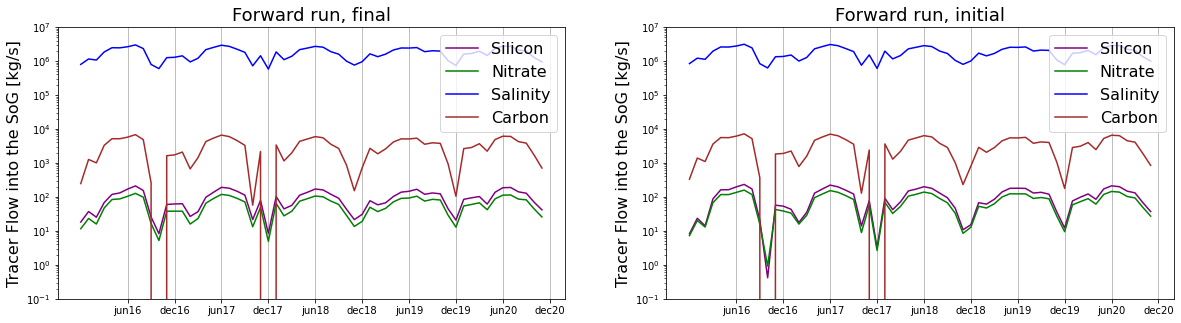

In [92]:
# fig, ax = plt.subplots(1, 2, figsize = (20, 5))

# ax[0].plot(sili_sum_for,label='Silicon', c='purple')
# ax[0].plot(nitr_sum_for,label='Nitrate', c='green')
# ax[0].plot(saln_sum_for,label='Salinity', c='b')
# ax[0].plot(carb_sum_for,label='Carbon', c='brown')

# ax[0].legend(fontsize = 16)
# ax[0].set_yscale('log')
# ax[0].set_xticks(np.arange(6,61,6))
# ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax[0].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
# ax[0].grid(axis='x', which='both')
# ax[0].set_title("Forward run, final",fontsize = 18)
# ax[0].set_ylim(0.1,10**7)

# ax[1].plot(sili_sum_for_I,label='Silicon', c='purple')
# ax[1].plot(nitr_sum_for_I,label='Nitrate', c='green')
# ax[1].plot(saln_sum_for_I,label='Salinity', c='b')
# ax[1].plot(carb_sum_for_I,label='Carbon', c='brown')

# ax[1].legend(fontsize = 16)
# ax[1].set_yscale('log')
# ax[1].set_xticks(np.arange(6,61,6))
# ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax[1].set_ylabel('Tracer Flow into the SoG [kg/s]', fontsize = 16)
# ax[1].grid(axis='x', which='both')
# ax[1].set_title("Forward run, initial",fontsize = 18)
# ax[1].set_ylim(0.1,10**7)

(0.1, 10000000)

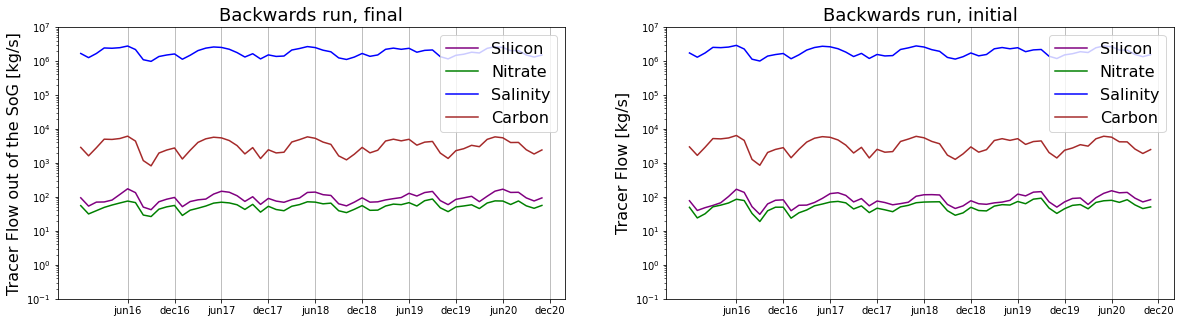

In [93]:
# fig, ax = plt.subplots(1, 2, figsize = (20, 5))

# ax[0].plot(sili_sum_back,label='Silicon', c='purple')
# ax[0].plot(nitr_sum_back,label='Nitrate', c='green')
# ax[0].plot(saln_sum_back,label='Salinity', c='b')
# ax[0].plot(carb_sum_back,label='Carbon', c='brown')

# ax[0].legend(fontsize = 16)
# ax[0].set_yscale('log')
# ax[0].set_xticks(np.arange(6,61,6))
# ax[0].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax[0].set_ylabel('Tracer Flow out of the SoG [kg/s]', fontsize = 16)
# ax[0].grid(axis='x', which='both')
# ax[0].set_title("Backwards run, final",fontsize = 18)
# ax[0].set_ylim(0.1,10**7)

# ax[1].plot(sili_sum_back_I,label='Silicon', c='purple')
# ax[1].plot(nitr_sum_back_I,label='Nitrate', c='green')
# ax[1].plot(saln_sum_back_I,label='Salinity', c='b')
# ax[1].plot(carb_sum_back_I,label='Carbon', c='brown')

# ax[1].legend(fontsize = 16)
# ax[1].set_yscale('log')
# ax[1].set_xticks(np.arange(6,61,6))
# ax[1].set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax[1].set_ylabel('Tracer Flow [kg/s]', fontsize = 16)
# ax[1].grid(axis='x', which='both')
# ax[1].set_title("Backwards run, initial",fontsize = 18)
# ax[1].set_ylim(0.1,10**7)